## Assignment 2


Team: <br>
LASRI Mouad 2021021597 <br>
GEMEDA Metasebia 2020010593

Import the required libraries

In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
import sys
import time
from IPython import display
from mpl_toolkits import mplot3d
from sklearn import datasets

#  Part 1- Three Layer Network 

The activation functions and their derivatives.

In [2]:
def relu(X):
    return np.maximum(X,0)

def relu_derivative(X):
    return 1.0 * (X>0) #.astype(float)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return (1.0-tanh(X)**2)

def logistic(X):
    return 1.0/(1.0+np.exp(-X))

def logistic_derivative(X):
    return (logistic(X)*(1.0-logistic(X)))

Now, this is the two-layer neural network that features two input dimensions, one fully-connected hidden layer, and a fully-connected output layer.

In [3]:
# create a two-layer neural network
def create_model(X,hidden_nodes,output_dim=2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    # save which activation function in the model.
    # the eval() function converts a string into a function
    # this way, we can directly call the appropriate activation function and its derative with just the string name
    # and we can avoid writing "if" statements for each activation function and derivatives
    model['activation_function'] = eval(activation_function);
    
    # set the model activation function derative using eval(), same logic as previous line
    model['activation_function_derivative'] = eval(activation_function + '_derivative')
    
    # input dimensionality
    input_dim = X.shape[1]
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes)/np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))
    
    # second set of weights from hidden layer 1 to output
    model['W2'] = np.random.randn(hidden_nodes, output_dim)/np.sqrt(hidden_nodes)
    # set of biases
    model['b2'] = np.zeros((1, output_dim))
    return model

# defines the forward pass given a model and data
def feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # first layer
    z1 = x.dot(W1) + b1
    
    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = model['activation_function'](z1)
    
    # second layer
    z2 = a1.dot(W2)+b2
    
    # no activation function as this is simply a linear layer!!
    out = z2
    return z1, a1, z2, out

# define the regression loss
def calculate_loss(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # what are the current predictions
    z1, a1, z2, out = feed_forward(model, X)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2*(np.sum(np.square(W1))+ np.sum(np.square(W2)))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,model,z1,a1,z2,output,reg_lambda):
    
    # derivative of loss function
    delta3 = (output-y)/X.shape[0]
    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3)
    # and over all neurons
    db2 = np.sum(delta3, axis =0, keepdims=True) #different because it is not being multiplied by all the weights, only 1
    
    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T)*logistic_derivative(a1) #if logistic
    #delta2 = ... #if tanh
    delta2 = delta3.dot(model['W2'].T)*  model['activation_function_derivative'](a1) #if ReLU
    
    # multiply by input data
    dW1 = (X.T).dot(delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    
    # add regularization terms on the two weights
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2, db1, db2

# simple training loop
def train(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, tol_thresh=0.001, sgd_status = True):
    # whether to do stochastic gradient descent
    sgd = sgd_status
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False) #bad programming because we dont know the number of  data points needed , 30 is random
            # get predictions
            z1,a1,z2,output = feed_forward(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X[randinds,:],y[randinds],model,z1,a1,z2,output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2,output = feed_forward(model, X)
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X,y,model,z1,a1,z2,output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses, i

## Extend the fully-connected two layer perceptron shown in class for the regression problem by one more layer to have two hidden layers.

Now, let's create a three-layer neural network that features two input dimensions, two fully-connected hidden layer, and a fully-connected output layer.

In [4]:
# create a three-layer neural network
def create_3L_model(X,hidden_nodes1, hidden_nodes2, output_dim=2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    # save which activation function in the model.
    # the eval() function converts a string into a function
    # this way, we can directly call the appropriate activation function and its derative with just the string name
    # and we can avoid writing "if" statements for each activation function and derivatives
    model['activation_function'] = eval(activation_function);
    
    # set the model activation function derative using eval(), same logic as previous line
    model['activation_function_derivative'] = eval(activation_function + '_derivative')
    
    # input dimensionality
    input_dim = X.shape[1]
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes1)/np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes1))
    
    # second set of weights from hidden layer 1 to hidden layer2
    model['W2'] = np.random.randn(hidden_nodes1, hidden_nodes2)/np.sqrt(hidden_nodes1)
    # set of biases
    model['b2'] = np.zeros((1, hidden_nodes2))
    
    
    # second set of weights from hidden layer 2 to output
    model['W3'] = np.random.randn(hidden_nodes2, output_dim)/np.sqrt(hidden_nodes2)
    # set of biases
    model['b3'] = np.zeros((1, output_dim))
    return model

# defines the forward pass given a model and data
def feed_forward_3L(model, x):
    # get weights and biases
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # first layer
    z1 = x.dot(W1) + b1
    
    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = model['activation_function'](z1)
    
    # second layer
    z2 = a1.dot(W2)+b2
    
    a2 = model['activation_function'](z2)
    
    # third layer
    z3 = a2.dot(W3)+b3
    
    
    
    # no activation function as this is simply a linear layer!!
    out = z3
    return z1, a1, z2, a2, z3, out

# define the regression loss
def calculate_loss_3L(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2, W3, b3  = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # what are the current predictions
    z1, a1, z2, a2, z3, out = feed_forward_3L(model, X)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2*(np.sum(np.square(W1))+ np.sum(np.square(W2))+ np.sum(np.square(W3)))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop_3L(X,y,model,z1,a1,z2,a2, z3,output,reg_lambda):
     # derivative of loss function
    delta4 = (output-y)/X.shape[0]
    # multiply this by activation outputs of hidden layer
    dW3 = (a2.T).dot(delta4)
    # and over all neurons
    db3 = np.sum(delta4, axis =0, keepdims=True) #different because it is not being multiplied by all the weights, only 1
    
    
    # derivative of activation function
    delta3 = delta4.dot(model['W3'].T)*  model['activation_function_derivative'](a2) #if ReLU
    # multiply by input data
    dW2 = (a1.T).dot(delta3)
    # and sum over all neurons
    db2 = np.sum(delta3, axis=0)
    
    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T)*logistic_derivative(a1) #if logistic
    #delta2 = ... #if tanh
    delta2 = delta3.dot(model['W2'].T)*  model['activation_function_derivative'](a1) #if ReLU
    
    # multiply by input data
    dW1 = (X.T).dot(delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    
    # add regularization terms on the two weights
    dW3 += reg_lambda * model['W3']
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2,dW3, db1, db2, db3
    
    
# simple training loop
def train_3L(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, tol_thresh=0.001, sgd_status = True ):
    # whether to do stochastic gradient descent
    sgd = sgd_status
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False) #bad programming because we dont know the number of  data points needed , 30 is random
            # get predictions
            z1,a1,z2, a2, z3, output = feed_forward_3L(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, dW3, db1, db2, db3 = backprop_3L(X[randinds,:],y[randinds],model,z1,a1,z2,a2, z3, output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2, a2, z3, output = feed_forward_3L(model, X)
            # feed this into backprop
            dW1, dW2, dW3, db1, db2, db3 = backprop_3L(X,y,model,z1,a1,z2,a2, z3, output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W3'] -= learning_rate * dW3
        model['b3'] -= learning_rate * db3
        
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss_3L(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses, i

## Series of tests

In [5]:
#comparing 2 layer NN with 3 layer one 

numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

# training set size
num_examples = len(X) 
# input layer dimensionality
nn_input_dim = 2 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
#tolerance threshold
tol_thresh = 0.0001
#maximum iteration
num_passes =100000
#SGD status
sgd_status = False   # --> NO SGD
# regularization strength
reg_lambda = 0   #--> No regularization


TEST1

In [6]:
#--> TEST1

Loss_collection =[]
iterations_colection = np.zeros([10])
outputs_collection=[]
# create the models


#running the network 10 times
for i in range(10):
    model1 = create_model(X,8,output_dim=1) #take 8 neurons for the two-layer version
    #train it
    model1, losses1, iterations_colection[i] = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection.append(losses1)
    # determine predictions of the trained models
    outputs_collection.append(feed_forward(model1, X))


#model1, losses1 = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)

Loss after iteration 0: 1617.9187960374584
Loss after iteration 1000: 26.179219771409237


C:\Users\Meti\AppData\Local\Temp\ipykernel_10788\3503835815.py:129: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 2000: 10.147276503798647
Loss after iteration 3000: 7.6498136421134175
Loss after iteration 4000: 6.749215723335488
Loss after iteration 5000: 6.052288052376597
Loss after iteration 6000: 5.625969018115192
Loss after iteration 7000: 5.344969046541114
Loss after iteration 8000: 5.156287729397725
Loss after iteration 9000: 5.014073629338109
Loss after iteration 10000: 4.903744543052222
Loss after iteration 11000: 4.805023844821148
Loss after iteration 12000: 3.9046954946757486
Loss after iteration 13000: 3.7134538801376777
Loss after iteration 14000: 3.6399651581451944
Loss after iteration 15000: 3.588032476147553
Loss after iteration 16000: 3.555272781928208
Loss after iteration 17000: 3.525587076855246
Loss after iteration 18000: 3.4990429144502944
Loss after iteration 19000: 3.470075141558674
Loss after iteration 20000: 3.4509120309132735
Loss after iteration 21000: 3.4366920640334166
Loss after iteration 22000: 3.4175304532015645
Loss after iteration 23000: 3.407

Loss after iteration 16000: 4.367794176843963
Loss after iteration 17000: 4.3210301067060835
Loss after iteration 18000: 4.24354092694093
Loss after iteration 19000: 4.190234182867353
Loss after iteration 20000: 4.106841442552075
Loss after iteration 21000: 3.9464361858416668
Loss after iteration 22000: 3.869269989416284
Loss after iteration 23000: 3.8079280251616727
Loss after iteration 24000: 3.7566571624841516
Loss after iteration 25000: 3.709993246996569
Loss after iteration 26000: 3.6586250163080836
Loss after iteration 27000: 3.6158393254587877
Loss after iteration 28000: 3.579884360485132
Loss after iteration 29000: 3.5538383159219333
Loss after iteration 30000: 3.532643566191414
Loss after iteration 31000: 3.5145661439424583
Loss after iteration 32000: 3.499026209795213
Loss after iteration 33000: 3.485563078422285
Loss after iteration 34000: 3.466961377761287
Loss after iteration 35000: 3.450509331395428
Loss after iteration 36000: 3.435899197089868
Loss after iteration 37000:

Loss after iteration 94000: 3.3689695684802223
Loss after iteration 95000: 3.3672583612638967
Loss after iteration 96000: 3.3657909257837804
Loss after iteration 97000: 3.364566959948763
Loss after iteration 98000: 3.3635318846125393
Loss after iteration 99000: 3.3626967544571786
Loss after iteration 0: 1305.8847382798688
Loss after iteration 1000: 24.988884770914037
Loss after iteration 2000: 10.368364333587529
Loss after iteration 3000: 7.56325593540124
Loss after iteration 4000: 6.152388035942388
Loss after iteration 5000: 5.642465728078648
Loss after iteration 6000: 5.276979228919138
Loss after iteration 7000: 5.086208773935162
Loss after iteration 8000: 4.958231381103427
Loss after iteration 9000: 4.852441771164186
Loss after iteration 10000: 4.7448063357720915
Loss after iteration 11000: 4.670548388332611
Loss after iteration 12000: 4.605301969682827
Loss after iteration 13000: 4.526728533379654
Loss after iteration 14000: 4.458858899444621
Loss after iteration 15000: 4.414977338

Loss after iteration 12000: 3.0748442990041283
Loss after iteration 13000: 3.0147420797947153
Loss after iteration 14000: 2.972679164255958
Loss after iteration 15000: 2.9443583996898934
Loss after iteration 16000: 2.9202872463942615
Loss after iteration 17000: 2.901797673153554
Loss after iteration 18000: 2.889344935776233
Loss after iteration 19000: 2.8785167089458414
Loss after iteration 20000: 2.8659883067708294
Loss after iteration 21000: 2.856935145857806
Loss after iteration 22000: 2.8504742055171595
Loss after iteration 23000: 2.8459377205235405
Loss after iteration 24000: 2.842578226589577
Loss after iteration 25000: 2.839994077535742
Loss after iteration 26000: 2.837954533067259
Loss after iteration 27000: 2.8362957459057827
Loss after iteration 28000: 2.8349108793480475
Loss after iteration 29000: 2.8337312596255084
Loss after iteration 30000: 2.8327087302121208
Loss after iteration 31000: 2.8284181337589405
Loss after iteration 32000: 2.825961798200172
Loss after iteration 

Loss after iteration 18000: 5.1552153829394785
Loss after iteration 19000: 5.1407456581985915
Loss after iteration 20000: 5.128011325651237
Loss after iteration 21000: 5.1150853263728875
Loss after iteration 22000: 5.099881135065332
Loss after iteration 23000: 5.08841883067121
Loss after iteration 24000: 5.078466384350914
Loss after iteration 25000: 5.069692052575831
Loss after iteration 26000: 5.061890208521573
Loss after iteration 27000: 5.054930357542845
Loss after iteration 28000: 5.048667833451952
Loss after iteration 29000: 5.043060407949355
Loss after iteration 30000: 5.038027354793816
Loss after iteration 31000: 5.033492673080861
Loss after iteration 32000: 5.029410456414018
Loss after iteration 33000: 5.025717313327245
Loss after iteration 34000: 4.9571052349616025
Loss after iteration 35000: 4.762123060887326
Loss after iteration 36000: 4.598030832198332
Loss after iteration 37000: 4.4381412207676885
Loss after iteration 38000: 4.388057547587052
Loss after iteration 39000: 4.

In [7]:
#--> TEST1(Continued for 3L)
# create the 3 layer model

Loss_collection2 =[]
iterations_colection2 = np.zeros([10])
outputs_collection2=[]
# create the models


#running the network 10 times
for i in range(10):
    model2 = create_3L_model(X,4,4 ,output_dim=1) #take 4+4 neurons for the three-layer version
    #train it
    model2, losses2, iterations_colection2[i] = train_3L(model2,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection2.append(losses2)
    # determine predictions of the trained models
    outputs_collection2.append(feed_forward_3L(model2, X))




Loss after iteration 0: 1686.669413617583


C:\Users\Meti\AppData\Local\Temp\ipykernel_10788\1279318385.py:154: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 1000: 27.755469612321047
Loss after iteration 2000: 24.592737626784043
Loss after iteration 3000: 22.41735077677526
Loss after iteration 4000: 21.12793136574998
Loss after iteration 5000: 21.459198815125372
Loss after iteration 6000: 20.704356573987962
Loss after iteration 7000: 19.151665423641195
Loss after iteration 8000: 17.98003737863276
Loss after iteration 9000: 15.465516339018901
Loss after iteration 10000: 16.008394719975062
Loss after iteration 11000: 15.467322627035776
Loss after iteration 12000: 15.002640027825866
Loss after iteration 13000: 14.36869529567131
Loss after iteration 14000: 13.818190991418236
Loss after iteration 15000: 14.264770409928056
Loss after iteration 16000: 13.345336819738513
Loss after iteration 17000: 13.409410798804128
Loss after iteration 18000: 12.818652768233987
Loss after iteration 19000: 14.443129040693606
Loss after iteration 20000: 10.50766592031861
Loss after iteration 21000: 12.357695688773559
Loss after iteration 22000:

Loss after iteration 20000: 10.562699298100931
Loss after iteration 21000: 9.805917669055786
Loss after iteration 22000: 9.71759377823107
Loss after iteration 23000: 9.762461075504119
Loss after iteration 24000: 9.943651189602436
Loss after iteration 25000: 9.840729801275751
Loss after iteration 26000: 9.554356380433981
Loss after iteration 27000: 9.609020295114668
Loss after iteration 28000: 9.259431836739877
Loss after iteration 29000: 8.919673102684543
Loss after iteration 30000: 8.75995073497695
Loss after iteration 31000: 8.730202545866609
Loss after iteration 32000: 8.641917027315754
Loss after iteration 33000: 8.459395011828123
Loss after iteration 34000: 8.48090849278961
Loss after iteration 35000: 8.460942975354866
Loss after iteration 36000: 8.369042011596399
Loss after iteration 37000: 8.335629880913611
Loss after iteration 38000: 8.285238078975873
Loss after iteration 39000: 7.876907353976254
Loss after iteration 40000: 8.376483262076716
Loss after iteration 41000: 8.115495

Loss after iteration 35000: 5.395632230873377
Loss after iteration 36000: 5.111335480630122
Loss after iteration 37000: 4.579218920666285
Loss after iteration 38000: 4.276731279670136
Loss after iteration 39000: 4.324938784301817
Loss after iteration 40000: 4.761254380103969
Loss after iteration 41000: 4.3568301145752075
Loss after iteration 42000: 4.487953164965643
Loss after iteration 43000: 4.821157441562075
Loss after iteration 44000: 4.3019907709898035
Loss after iteration 45000: 4.226691115628137
Loss after iteration 46000: 4.440330558028587
Loss after iteration 47000: 5.057179942524924
Loss after iteration 48000: 4.18196162016946
Loss after iteration 49000: 4.1893441622788155
Loss after iteration 50000: 4.6319740655565225
Loss after iteration 51000: 4.014123873248469
Loss after iteration 52000: 4.137850181368739
Loss after iteration 53000: 4.1520435178661455
Loss after iteration 54000: 3.888902483495751
Loss after iteration 55000: 3.7577417602344148
Loss after iteration 56000: 4

Loss after iteration 27000: 7.3773600968649236
Loss after iteration 28000: 6.8844974465702276
Loss after iteration 29000: 6.194535482942297
Loss after iteration 30000: 6.917952152729985
Loss after iteration 31000: 7.125959238176559
Loss after iteration 32000: 6.981481078920323
Loss after iteration 33000: 7.050319750880083
Loss after iteration 34000: 7.010378015398187
Loss after iteration 35000: 6.837362091981211
Loss after iteration 36000: 6.683546630779957
Loss after iteration 37000: 6.607014064127866
Loss after iteration 38000: 6.521832505958666
Loss after iteration 39000: 6.238379094325947
Loss after iteration 40000: 7.082601498986884
Loss after iteration 41000: 5.6206028715243965
Loss after iteration 42000: 6.7404881690881036
Loss after iteration 43000: 6.462213072370027
Loss after iteration 44000: 6.378047565153504
Loss after iteration 45000: 6.290890431105344
Loss after iteration 46000: 6.189431276069901
Loss after iteration 47000: 6.092903970618513
Loss after iteration 48000: 6.

Loss after iteration 4000: 25.70723138048289
Loss after iteration 5000: 24.636392511396448
Loss after iteration 6000: 22.352202946067013
Loss after iteration 7000: 20.79068781268025
Loss after iteration 8000: 20.224348490439212
Loss after iteration 9000: 14.159652840089677
Loss after iteration 10000: 13.0979544627237
Loss after iteration 11000: 11.974543595930594
Loss after iteration 12000: 10.020903561441864
Loss after iteration 13000: 8.4064820373226
Loss after iteration 14000: 8.68429206953635
Loss after iteration 15000: 9.179216777879839
Loss after iteration 16000: 7.994270647923996
Loss after iteration 17000: 8.306344591604251
Loss after iteration 18000: 6.932925277392221
Loss after iteration 19000: 8.23500035899579
Loss after iteration 20000: 6.5125405216613155
Loss after iteration 21000: 5.801334749155733
Loss after iteration 22000: 7.2163242107358
Loss after iteration 23000: 6.46819031396905
Loss after iteration 24000: 6.716825531855698
Loss after iteration 25000: 6.30758501925

Loss after iteration 84000: 5.157414681481969
Loss after iteration 85000: 5.046459393362078
Loss after iteration 86000: 5.078741298949878
Loss after iteration 87000: 5.077630557085916
Loss after iteration 88000: 5.063166391350538
Loss after iteration 89000: 5.031843054084705
Loss after iteration 90000: 4.999315498988815
Loss after iteration 91000: 4.993961503722581
Loss after iteration 92000: 4.965342130060716
Loss after iteration 93000: 4.949985545044488
Loss after iteration 94000: 4.944215049326742
Loss after iteration 95000: 4.920469676694139
Loss after iteration 96000: 5.023755875111059
Loss after iteration 97000: 5.021194095062437
Loss after iteration 98000: 5.005905919980618
Loss after iteration 99000: 4.988995042122197


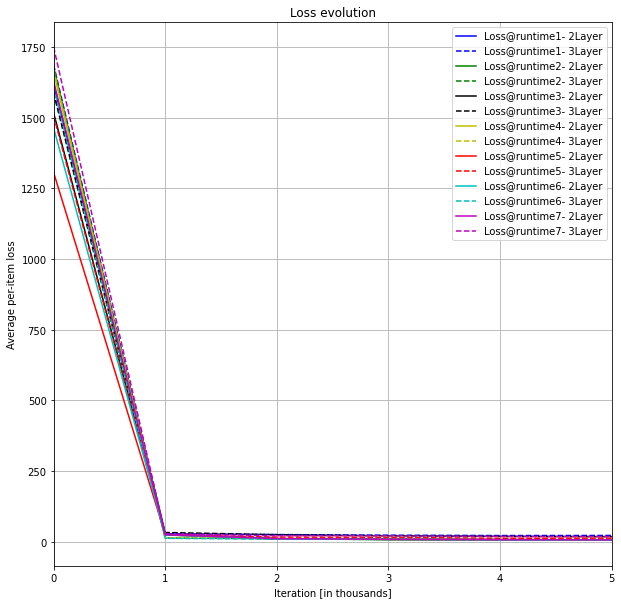

In [10]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot( Loss_collection[0], 'b',Loss_collection2[0], 'b--', Loss_collection[1], 'g',Loss_collection2[1], 'g--', Loss_collection[2], 'k',Loss_collection2[2], 'k--', Loss_collection[3], 'y',Loss_collection2[3], 'y--', Loss_collection[4], 'r',Loss_collection2[4], 'r--', Loss_collection[5], 'c',Loss_collection2[5], 'c--', Loss_collection[6], 'm',Loss_collection2[6], 'm--')

#plt.plot(Loss_collection2[0], 'g-')
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.legend(['Loss@runtime1- 2Layer', 'Loss@runtime1- 3Layer', 'Loss@runtime2- 2Layer', 'Loss@runtime2- 3Layer', 'Loss@runtime3- 2Layer', 'Loss@runtime3- 3Layer', 'Loss@runtime4- 2Layer', 'Loss@runtime4- 3Layer', 'Loss@runtime5- 2Layer', 'Loss@runtime5- 3Layer', 'Loss@runtime6- 2Layer', 'Loss@runtime6- 3Layer', 'Loss@runtime7- 2Layer', 'Loss@runtime7- 3Layer'])
plt.xlim([0, 5])
plt.grid()
plt.show()

The losses have various initial points as well as end points as stochastic gradient descent is removed and there is random weight initialization

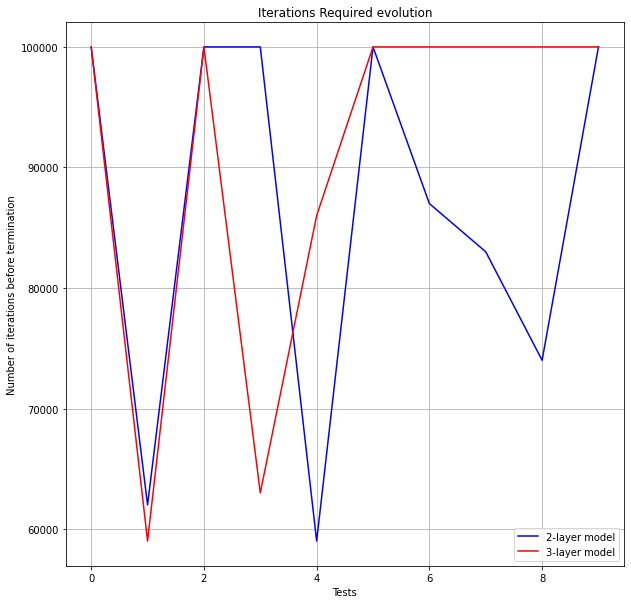

In [12]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot( iterations_colection, 'b',iterations_colection2, 'r')
plt.xlabel('Tests')
plt.ylabel('Number of iterations before termination')
plt.title('Iterations Required evolution')
plt.legend(['2-layer model' , '3-layer model'])
plt.grid()
plt.show()

Here we can observe that the number of iterations required is not the same for each run as SGD and regularizations are removed

Test 2

In [13]:
Loss_collection =[]
iterations_colection = np.zeros([10])
outputs_collection=[]
# create the model and running 10 times


#running the network 10 times
for i in range(10):
    model1 = create_model(X,16,output_dim=1) #take 8 neurons for the two-layer version
    #train it
    model1, losses1, iterations_colection[i] = train(model1,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection.append(losses1)
    # determine predictions of the trained models
    outputs_collection.append(feed_forward(model1, X))

Loss after iteration 0: 1561.980052110901


C:\Users\Meti\AppData\Local\Temp\ipykernel_10788\3503835815.py:129: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 1000: 23.1448882101304
Loss after iteration 2000: 8.841911755795165
Loss after iteration 3000: 6.171557147831519
Loss after iteration 4000: 4.146993317202515
Loss after iteration 5000: 2.9824364208063976
Loss after iteration 6000: 2.4603494706872646
Loss after iteration 7000: 2.125955320288768
Loss after iteration 8000: 1.9447995394149833
Loss after iteration 9000: 1.7676062052904753
Loss after iteration 10000: 1.6298550739655537
Loss after iteration 11000: 1.0182121354326095
Loss after iteration 12000: 0.8041435388662542
Loss after iteration 13000: 0.7199795796830195
Loss after iteration 14000: 0.674601179444235
Loss after iteration 15000: 0.618624510187693
Loss after iteration 16000: 0.5850861904873623
Loss after iteration 17000: 0.5591291484753379
Loss after iteration 18000: 0.5340359391351631
Loss after iteration 19000: 0.5174310357828321
Loss after iteration 20000: 0.5028102082347775
Loss after iteration 21000: 0.48653116387761575
Loss after iteration 22000: 0

Loss after iteration 77000: 0.686429560577121
Loss after iteration 78000: 0.6837591541199161
Loss after iteration 79000: 0.6803268852807071
Loss after iteration 80000: 0.6771001259949837
Loss after iteration 81000: 0.6739687184752507
Loss after iteration 82000: 0.6704607557143502
Loss after iteration 83000: 0.6664919487552311
Loss after iteration 84000: 0.6630707631240322
Loss after iteration 85000: 0.6592316917328243
Loss after iteration 86000: 0.6512005699972268
Loss after iteration 87000: 0.6465423186817059
Loss after iteration 88000: 0.642383201716737
Loss after iteration 89000: 0.6385384245839879
Loss after iteration 90000: 0.6350552746578473
Loss after iteration 91000: 0.6318412346333594
Loss after iteration 92000: 0.6287705916738678
Loss after iteration 93000: 0.6257714979734038
Loss after iteration 94000: 0.6220308238840468
Loss after iteration 95000: 0.6186092597025302
Loss after iteration 96000: 0.6153862370979841
Loss after iteration 97000: 0.6122470208651887
Loss after iter

Loss after iteration 53000: 1.2801916936261566
Loss after iteration 54000: 1.277278847631703
Loss after iteration 55000: 1.2746530696999652
Loss after iteration 56000: 1.272204080976146
Loss after iteration 57000: 1.2699551778806297
Loss after iteration 58000: 1.2678331337708708
Loss after iteration 59000: 1.2658764322374956
Loss after iteration 60000: 1.2640831680201574
Loss after iteration 61000: 1.2624324823979842
Loss after iteration 62000: 1.2609331557197452
Loss after iteration 63000: 1.2595333293357087
Loss after iteration 64000: 1.2568784792194778
Loss after iteration 65000: 1.2550345233739784
Loss after iteration 66000: 1.2536510991744274
Loss after iteration 67000: 1.248139900005171
Loss after iteration 68000: 1.246318590891882
Loss after iteration 69000: 1.2448737581607363
Loss after iteration 70000: 1.2436129711594863
Loss after iteration 71000: 1.2424950888336217
Loss after iteration 72000: 1.2414910143471432
Loss after iteration 73000: 1.2405634505706788
Loss after iterat

Loss after iteration 45000: 1.0122175122357717
Loss after iteration 46000: 1.006910969462922
Loss after iteration 47000: 1.0028956015482722
Loss after iteration 48000: 0.9995824844460751
Loss after iteration 49000: 0.9968246510529374
Loss after iteration 50000: 0.9945203738017468
Loss after iteration 51000: 0.992528820781923
Loss after iteration 52000: 0.9884582131243457
Loss after iteration 53000: 0.9860522635920613
Loss after iteration 54000: 0.9841316487000238
Loss after iteration 55000: 0.9825813052216288
Loss after iteration 56000: 0.9812780486281395
Loss after iteration 57000: 0.9801925059976415
Loss after iteration 58000: 0.9792796200069395
Loss after iteration 59000: 0.9785007010498079
Loss after iteration 60000: 0.9774962872461512
Loss after iteration 61000: 0.9765329033268682
Loss after iteration 62000: 0.9758387237955345
Loss after iteration 63000: 0.9752718507462749
Loss after iteration 64000: 0.9747926737820451
Loss after iteration 65000: 0.9743833121950213
Loss after iter

Loss after iteration 35000: 1.1389257573694052
Loss after iteration 36000: 1.1234289000323887
Loss after iteration 37000: 1.1090698528642766
Loss after iteration 38000: 1.094625111435337
Loss after iteration 39000: 1.0818258355991206
Loss after iteration 40000: 1.0712915847291853
Loss after iteration 41000: 1.0582504486747775
Loss after iteration 42000: 1.0476294091687748
Loss after iteration 43000: 1.038687340697264
Loss after iteration 44000: 1.0302540473271773
Loss after iteration 45000: 1.0191029409993486
Loss after iteration 46000: 1.0097893297368492
Loss after iteration 47000: 1.0008088371825505
Loss after iteration 48000: 0.9915418180543475
Loss after iteration 49000: 0.9823890025340676
Loss after iteration 50000: 0.9734940897040605
Loss after iteration 51000: 0.9647442535339996
Loss after iteration 52000: 0.9533993844296649
Loss after iteration 53000: 0.9438892739559797
Loss after iteration 54000: 0.931752683431308
Loss after iteration 55000: 0.9210649804156605
Loss after itera

Loss after iteration 10000: 0.9655563551685898
Loss after iteration 11000: 0.8287794110708558
Loss after iteration 12000: 0.7322684295963409
Loss after iteration 13000: 0.680742663913665
Loss after iteration 14000: 0.645725644520201
Loss after iteration 15000: 0.6176812748414515
Loss after iteration 16000: 0.5924002998962314
Loss after iteration 17000: 0.5736192941296387
Loss after iteration 18000: 0.5577913259272721
Loss after iteration 19000: 0.544370048804747
Loss after iteration 20000: 0.5316435779037515
Loss after iteration 21000: 0.5202650837365299
Loss after iteration 22000: 0.5113540069172166
Loss after iteration 23000: 0.5036301336122829
Loss after iteration 24000: 0.4967972065131159
Loss after iteration 25000: 0.4908181348919628
Loss after iteration 26000: 0.4856340324524956
Loss after iteration 27000: 0.4810663523714858
Loss after iteration 28000: 0.47644053181840906
Loss after iteration 29000: 0.4713947318668704
Loss after iteration 30000: 0.466409277739908
Loss after itera

In [14]:
#--> TEST2(Continued for 3L)
# creating the 3 layer model and running 10 times for 8+8 neurons

Loss_collection2 =[]
iterations_colection2 = np.zeros([10])
outputs_collection2=[]
# create the models


#running the network 10 times
for i in range(10):
    model2 = create_3L_model(X,8,8 ,output_dim=1) #take 4+4 neurons for the three-layer version
    #train it
    model2, losses2, iterations_colection2[i] = train_3L(model2,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate, tol_thresh=tol_thresh, sgd_status =False)
    # determine predictions of the trained models
    
    Loss_collection2.append(losses2)
    # determine predictions of the trained models
    outputs_collection2.append(feed_forward_3L(model2, X))

Loss after iteration 0: 1787.753935778901


C:\Users\Meti\AppData\Local\Temp\ipykernel_10788\1279318385.py:154: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < tol_thresh:


Loss after iteration 1000: 11.072872413238716
Loss after iteration 2000: 7.58397971892134
Loss after iteration 3000: 6.331412385989327
Loss after iteration 4000: 6.1976138650176615
Loss after iteration 5000: 3.4448349817446995
Loss after iteration 6000: 4.28266166698014
Loss after iteration 7000: 3.569525086492885
Loss after iteration 8000: 3.166087714160047
Loss after iteration 9000: 3.8853219625329185
Loss after iteration 10000: 2.6445246537541327
Loss after iteration 11000: 2.432961223704517
Loss after iteration 12000: 2.2557094664708432
Loss after iteration 13000: 2.2923532809001315
Loss after iteration 14000: 2.020331926477268
Loss after iteration 15000: 2.2435975850745997
Loss after iteration 16000: 2.146221333845838
Loss after iteration 17000: 2.095688895962215
Loss after iteration 18000: 2.2048055524427186
Loss after iteration 19000: 1.996858085352071
Loss after iteration 20000: 1.9217912336670038
Loss after iteration 21000: 1.705446989097463
Loss after iteration 22000: 2.11580

Loss after iteration 78000: 0.5589555042018014
Loss after iteration 79000: 0.5546788179945993
Loss after iteration 80000: 0.5514528705698843
Loss after iteration 81000: 0.5484186332579979
Loss after iteration 82000: 0.544646721383029
Loss after iteration 83000: 0.5420216619019124
Loss after iteration 84000: 0.5395423684388013
Loss after iteration 85000: 0.5370370190272163
Loss after iteration 86000: 0.5346595193573798
Loss after iteration 87000: 0.5322298721838125
Loss after iteration 88000: 0.528085526314375
Loss after iteration 89000: 0.5461435909176647
Loss after iteration 90000: 0.5331294237545081
Loss after iteration 91000: 0.528681076714617
Loss after iteration 92000: 0.5251126078132449
Loss after iteration 93000: 0.5217067554430364
Loss after iteration 94000: 0.5163542132519695
Loss after iteration 95000: 0.4686548801752436
Loss after iteration 96000: 0.4882179957798269
Loss after iteration 97000: 0.49146271063031616
Loss after iteration 98000: 0.4916979435138147
Loss after iter

Loss after iteration 54000: 0.4361869092913917
Loss after iteration 55000: 0.4523470739582586
Loss after iteration 56000: 0.5606729897509962
Loss after iteration 57000: 0.41728318727610825
Loss after iteration 58000: 0.43943228831344383
Loss after iteration 59000: 0.5078638168809871
Loss after iteration 60000: 0.4681017928961749
Loss after iteration 61000: 0.4436723580925214
Loss after iteration 62000: 0.7000100294714632
Loss after iteration 63000: 0.4392071303910599
Loss after iteration 64000: 0.4794552328218903
Loss after iteration 65000: 0.5418061530154268
Loss after iteration 66000: 1.0549799032557776
Loss after iteration 67000: 0.5400660441952928
Loss after iteration 68000: 0.6929024220584298
Loss after iteration 69000: 1.614455306796005
Loss after iteration 70000: 0.45773771119731865
Loss after iteration 71000: 0.4158612800480902
Loss after iteration 72000: 0.5434591389839247
Loss after iteration 73000: 0.5028934975028004
Loss after iteration 74000: 0.45227541605422944
Loss after

Loss after iteration 30000: 1.1265296862440797
Loss after iteration 31000: 1.1538862250725477
Loss after iteration 32000: 1.1433769988187636
Loss after iteration 33000: 1.1531236028878795
Loss after iteration 34000: 1.0926050335663757
Loss after iteration 35000: 1.1111398756638422
Loss after iteration 36000: 1.0869478717873187
Loss after iteration 37000: 1.092995669854404
Loss after iteration 38000: 1.1222007138243968
Loss after iteration 39000: 1.1190707073060524
Loss after iteration 40000: 1.1369603031462732
Loss after iteration 41000: 1.101504534167042
Loss after iteration 42000: 1.0834469518216991
Loss after iteration 43000: 1.0659048599141432
Loss after iteration 44000: 1.0565145142735335
Loss after iteration 45000: 1.0265300416845966
Loss after iteration 46000: 1.004733944241713
Loss after iteration 47000: 0.9880336061626502
Loss after iteration 48000: 0.971320304886514
Loss after iteration 49000: 0.9486714922180411
Loss after iteration 50000: 0.9642905796368146
Loss after iterat

Loss after iteration 30000: 1.07176186568838
Loss after iteration 31000: 1.0211225813969849
Loss after iteration 32000: 0.7448139068431067
Loss after iteration 33000: 0.5006686570467869
Loss after iteration 34000: 0.5393559455792017
Loss after iteration 35000: 1.4556378305817985
Loss after iteration 36000: 1.4472688814928256
Loss after iteration 37000: 0.6089538369181239
Loss after iteration 38000: 0.5306356999106955
Loss after iteration 39000: 0.7279268878396842
Loss after iteration 40000: 0.8837933419218006
Loss after iteration 41000: 0.9006531000362159
Loss after iteration 42000: 0.7383106102675354
Loss after iteration 43000: 0.5999174759544298
Loss after iteration 44000: 0.9024881993033318
Loss after iteration 45000: 0.81872885278076
Loss after iteration 46000: 0.6447635662962844
Loss after iteration 47000: 0.46771141781409786
Loss after iteration 48000: 0.41525693527647417
Loss after iteration 49000: 0.40334691140510953
Loss after iteration 50000: 0.3961459235833255
Loss after ite

Loss after iteration 6000: 4.653164252411874
Loss after iteration 7000: 3.681155515530659
Loss after iteration 8000: 3.07026616191886
Loss after iteration 9000: 2.992152191543267
Loss after iteration 10000: 1.7371672770076636
Loss after iteration 11000: 1.6212195249861618
Loss after iteration 12000: 1.3397243137727595
Loss after iteration 13000: 1.647574661548492
Loss after iteration 14000: 1.4140945462317935
Loss after iteration 15000: 1.5079443025798713
Loss after iteration 16000: 1.3482874631489
Loss after iteration 17000: 1.280545414720498
Loss after iteration 18000: 1.254117348652247
Loss after iteration 19000: 1.1833741030488922
Loss after iteration 20000: 1.183159421820946
Loss after iteration 21000: 1.0680183534838497
Loss after iteration 22000: 1.2033152525067712
Loss after iteration 23000: 0.9620682864946685
Loss after iteration 24000: 1.0775140382748651
Loss after iteration 25000: 1.046039202060374
Loss after iteration 26000: 1.0286317893365406
Loss after iteration 27000: 0.

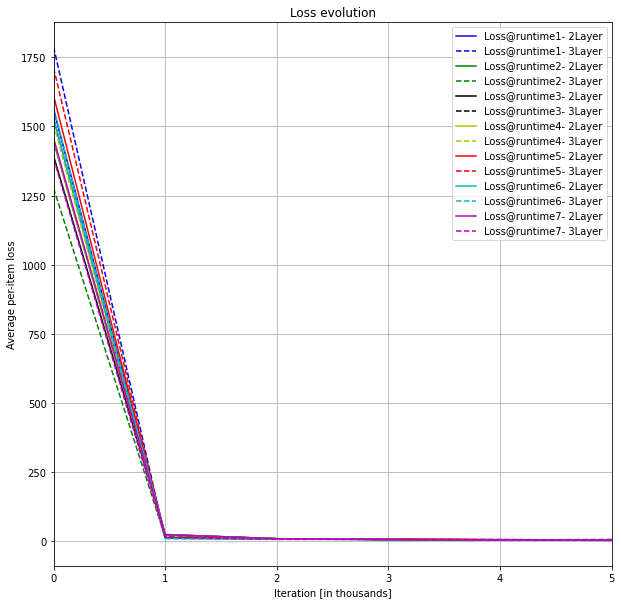

In [15]:

plt.figure(figsize=(10,10))
plt.plot( Loss_collection[0], 'b',Loss_collection2[0], 'b--', Loss_collection[1], 'g',Loss_collection2[1], 'g--', Loss_collection[2], 'k',Loss_collection2[2], 'k--', Loss_collection[3], 'y',Loss_collection2[3], 'y--', Loss_collection[4], 'r',Loss_collection2[4], 'r--', Loss_collection[5], 'c',Loss_collection2[5], 'c--', Loss_collection[6], 'm',Loss_collection2[6], 'm--')

#plt.plot(Loss_collection2[0], 'g-')
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.legend(['Loss@runtime1- 2Layer', 'Loss@runtime1- 3Layer', 'Loss@runtime2- 2Layer', 'Loss@runtime2- 3Layer', 'Loss@runtime3- 2Layer', 'Loss@runtime3- 3Layer', 'Loss@runtime4- 2Layer', 'Loss@runtime4- 3Layer', 'Loss@runtime5- 2Layer', 'Loss@runtime5- 3Layer', 'Loss@runtime6- 2Layer', 'Loss@runtime6- 3Layer', 'Loss@runtime7- 2Layer', 'Loss@runtime7- 3Layer'])
plt.xlim([0, 5])
plt.grid()
plt.show()

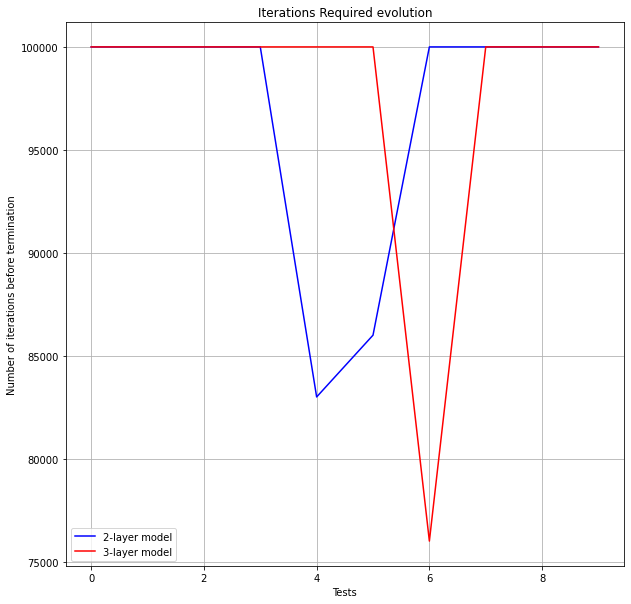

In [16]:

plt.figure(figsize=(10,10))
plt.plot( iterations_colection, 'b',iterations_colection2, 'r')
plt.xlabel('Tests')
plt.ylabel('Number of iterations before termination')
plt.title('Iterations Required evolution')
plt.legend(['2-layer model' , '3-layer model'])
plt.grid()
plt.show()

As the number of neurons increase, we can see that training till maximum iteration becomes more common

## Part2 Pytorch version

Adapt the code from class to solve the exact same regression problem with three layers and the same number of
parameters. Use the ‘“nn” layers. Visualize the network architecture as well.


In [17]:
import seaborn as sb
import pandas
import torch

In [22]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=torch.linspace(-8,8,numDataOne)
ys=torch.linspace(-8,8,numDataOne)
counter=0
X2=torch.zeros([numData,2])
y2=torch.zeros([numData,1])
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X2[counter,0]=xs[r]
        X2[counter,1] = ys[c]
        y2[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

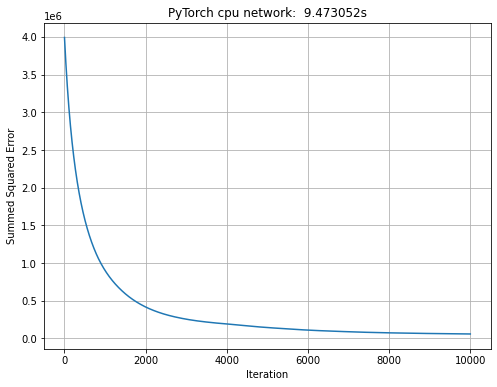

In [33]:
doGPU=False
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
start=time.time()

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 64, 2, 16, 16, 1
model = torch.nn.Sequential(torch.nn.Linear(D_in, H1), torch.nn.ReLU(), torch.nn.Linear(H1, H2), torch.nn.ReLU(), torch.nn.Linear(H2, D_out)).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        size = m.weight.size() # returns a tuple
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        m.weight.data = torch.randn(fan_out, fan_in, device=device)

model.apply(weights_init)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction ='sum')

learning_rate = 1e-9
max_iterations = 10000
l2_errors = np.zeros(max_iterations)

for it in range(max_iterations):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(X2)
    
    
    
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y2)
    l2_errors[it] = loss.item()

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

In [34]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


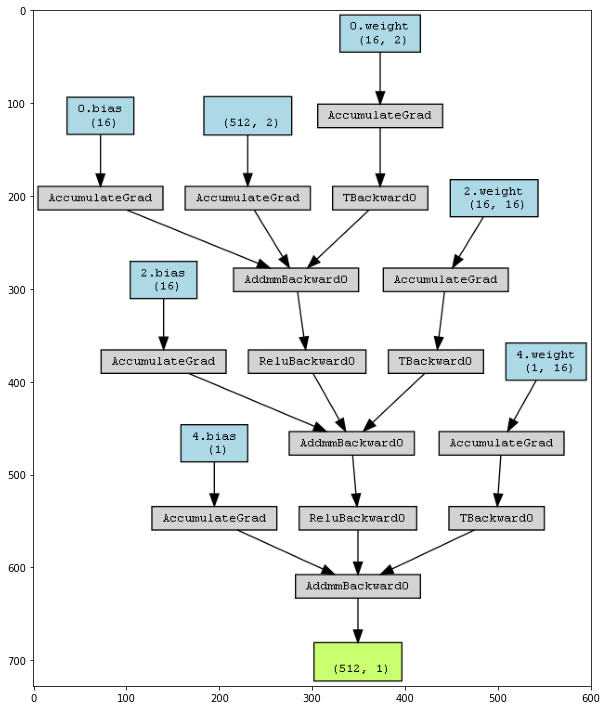

In [35]:
from torchviz import make_dot
import matplotlib.image as mpimg
x = torch.randn(512, 2).requires_grad_(True).to(device)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("torchviz", format="png")
%matplotlib inline
plt.figure(figsize=(10,20))
img = mpimg.imread('torchviz.png')
plt.imshow(img)
plt.show()

Test the network ten times with ADAM optimizer and ten times with SGD optimizer,
using a suitably high number of iterations.

In [36]:
doGPU=False
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
total_time=np.zeros([10])

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 64, 2, 16, 16, 1


max_iterations = 500
l2_errors = np.zeros(max_iterations)

#RUNNING TEN TIMES WITH adam OPTIMIZER
learning_rate = 1e-4

Loss_collection3 =[]
for jj in range(10):
    start=time.time()
    model = torch.nn.Sequential(torch.nn.Linear(D_in, H1), torch.nn.ReLU(), torch.nn.Linear(H1, H2), torch.nn.ReLU(), torch.nn.Linear(H2, D_out)).to(device)

    def weights_init(m):
        if isinstance(m, torch.nn.Linear):
            size = m.weight.size() # returns a tuple
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data = torch.randn(fan_out, fan_in, device=device)

    model.apply(weights_init)


    loss_fn = torch.nn.MSELoss(reduction ='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for it in range(max_iterations):
        # Forward pass: compute predicted y by passing x to the model.
        y_pred =  model(X2)

        # Compute and print loss.
        loss = loss_fn(y_pred, y2)
        l2_errors[it] = loss.item()

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward(retain_graph=True)

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    Loss_collection3.append(l2_errors)

    total_time[jj] = time.time()-start


In [37]:
doGPU=False
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
total_time4=np.zeros([10])

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 64, 2, 16, 16, 1


max_iterations = 500
l2_errors = np.zeros(max_iterations)

#RUNNING TEN TIMES WITH SGD OPTIMIZER
learning_rate = 1e-4

Loss_collection4 =[]
for jj in range(10):
    start=time.time()
    model = torch.nn.Sequential(torch.nn.Linear(D_in, H1), torch.nn.ReLU(), torch.nn.Linear(H1, H2), torch.nn.ReLU(), torch.nn.Linear(H2, D_out)).to(device)

    def weights_init(m):
        if isinstance(m, torch.nn.Linear):
            size = m.weight.size() # returns a tuple
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data = torch.randn(fan_out, fan_in, device=device)

    model.apply(weights_init)


    loss_fn = torch.nn.MSELoss(reduction ='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for it in range(max_iterations):
        # Forward pass: compute predicted y by passing x to the model.
        y_pred =  model(X2)

        # Compute and print loss.
        loss = loss_fn(y_pred, y2)
        l2_errors[it] = loss.item()

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward(retain_graph=True)

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    Loss_collection4.append(l2_errors)

    total_time4[jj] = time.time()-start

In [ ]:
%matplotlib notebook
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(Loss_collection3[0],'b', Loss_collection3[])
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

<IPython.core.display.Javascript object>


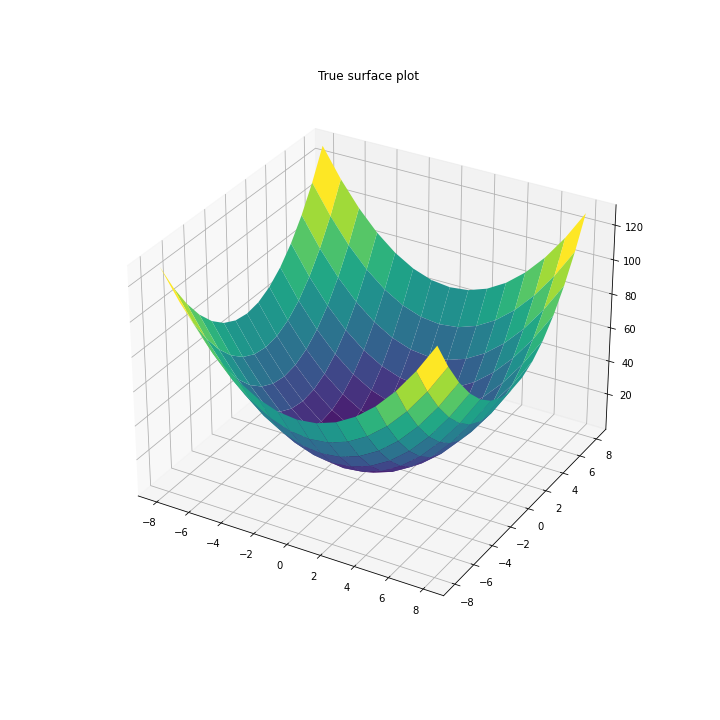

<IPython.core.display.Javascript object>


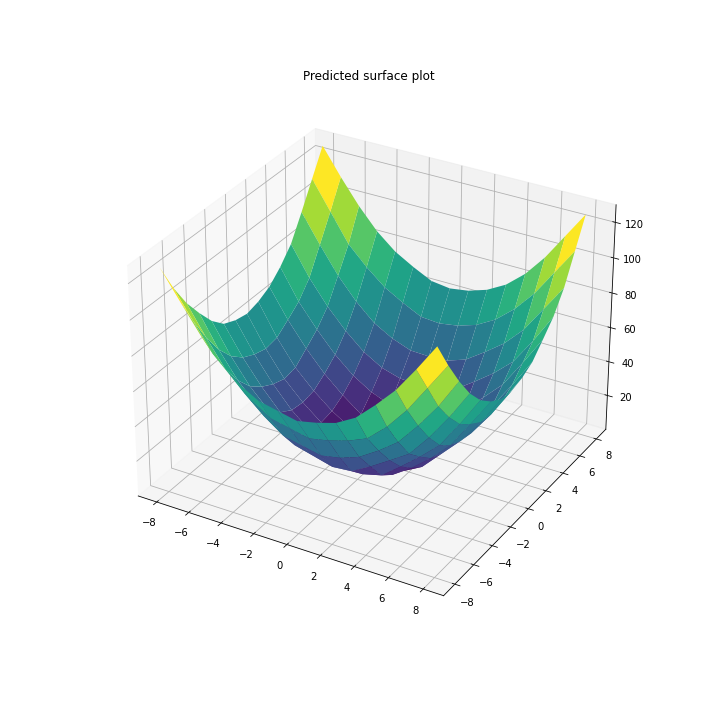

In [17]:
# plot data
[xsm,ysm]=np.meshgrid(xs,ys)
target = np.zeros((numDataOne,numDataOne))
for i,x in enumerate(xs):
    for j,y in enumerate(ys):
        target[i,j]=x**2+y**2+1.  #we can try and see how well the function does for different target functions

%matplotlib notebook
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, target,cmap='viridis', edgecolor='none')
ax.set_title('True surface plot')
plt.show()

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, np.reshape(output[4],(numDataOne,numDataOne)),cmap='viridis', edgecolor='none')
ax.set_title('Predicted surface plot')
plt.show()